In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science'])
plt.rcParams.update({'font.size': 24, 'text.usetex': True})

torch.set_default_device('cuda')
torch.set_default_dtype(torch.float64)
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 4070 Laptop GPU'

## Random Matrix Definition

We generate random $N \times N$ complex matrices where each entry is drawn from a standard complex Gaussian distribution:

$$A_{ij} \sim \mathcal{CN}(0, 1)$$

where the real and imaginary parts are independently drawn from $\mathcal{N}(0, 1/2)$.

After generation, we normalize the matrix so that the sum of absolute values of all entries equals 1:

$$A_{\text{normalized}} = \frac{A}{\sum_{i,j} |A_{ij}|}$$

This normalization ensures that matrices of different sizes have comparable error metrics.

In [2]:
def generate_random_normalized_matrix(N):
    """Generate random NxN matrix with sum of absolute values equal to 1"""
    # Generate random matrix (real or complex)
    A = torch.randn(N, N, dtype=torch.complex128)
    # Normalize by sum of absolute values
    A = A / torch.sum(torch.abs(A))
    return A

## Principal Component Approximation

Given a matrix $A$, we compute its eigendecomposition:

$$A = V \Lambda V^{-1}$$

where $\Lambda$ is the diagonal matrix of eigenvalues and $V$ is the matrix of eigenvectors.

For a rank-$d$ approximation, we keep only the $d$ eigenvalues with the largest absolute values and their corresponding eigenvectors:

$$A_d = V_d \Lambda_d V_d^{-1}$$

The reconstruction error is measured as:

$$\text{Error} = \sum_{i,j} |A_{ij} - (A_d)_{ij}|$$

In [3]:
def get_principal_components(A, d):
    """Get rank-d approximation using top d eigenvalues/eigenvectors"""
    # Eigendecomposition
    eigenvalues, eigenvectors = torch.linalg.eig(A)
    
    # Sort by absolute value (descending)
    abs_eigs = torch.abs(eigenvalues)
    indices = torch.argsort(abs_eigs, descending=True)
    
    # Take top d eigenvalues and eigenvectors
    top_eigenvalues = eigenvalues[indices[:d]]
    top_eigenvectors = eigenvectors[:, indices[:d]]
    
    # Reconstruct: A_d = V @ diag(lambda) @ V^{-1}
    # For general matrices, V^{-1} needs to be computed
    V = top_eigenvectors
    Lambda = torch.diag(top_eigenvalues)
    V_inv = torch.linalg.pinv(V)  # Use pseudo-inverse for stability
    
    A_d = V @ Lambda @ V_inv
    
    return A_d

def compute_error(A, A_d):
    """Compute sum of absolute values of entries of A - A_d"""
    diff = A - A_d
    error = torch.sum(torch.abs(diff)).item()
    return error

## Experiment: Varying Matrix Size and Number of Components

We now run experiments for different matrix sizes $N$ and varying numbers of principal components $d \in \{1, 2, \ldots, N\}$. Each experiment is repeated multiple times to compute mean and standard deviation of the reconstruction error.

In [4]:
# # Parameters
# N_values = [4, 8, 16, 32]
# n_runs = 256

# # Storage for results (one dict per N value)
# results = {}

# print(f"Running experiments with N in {N_values}, {n_runs} runs per (N, d) pair...\n")

# for N in N_values:
#     print(f"Running for N={N}...")
#     d_values = range(1, N+1)
#     mean_errors = []
#     std_errors = []
    
#     for d in d_values:
#         errors = []
#         for run in range(n_runs):
#             # Generate random matrix
#             A = generate_random_normalized_matrix(N)
            
#             # Get principal components
#             A_d = get_principal_components(A, d)
            
#             # Compute error
#             error = compute_error(A, A_d)
#             errors.append(error)
        
#         mean_error = np.mean(errors)
#         std_error = np.std(errors)
#         mean_errors.append(mean_error)
#         std_errors.append(std_error)
    
#     results[N] = {
#         'd_values': list(d_values),
#         'mean_errors': mean_errors,
#         'std_errors': std_errors
#     }
    
#     print(f"  N={N}: Final error at d=N: {mean_errors[-1]:.2e}")

# print("\nAll experiments completed!")

## Results: Combined Plot

We plot all results on a single figure, showing how reconstruction error decreases as we include more principal components for different matrix sizes.

### Theoretical Explanation: Universal Scaling with d/N

The observation that the error curves collapse when plotted against $d/N$ (rather than $d$ alone) has a solid theoretical foundation rooted in **random matrix theory**.

#### Key Insight: Eigenvalue Distribution Scaling

For large random matrices from the Gaussian Unitary Ensemble (GUE), the eigenvalue distribution follows the **Marchenko-Pastur law** (for rectangular matrices) or the **Wigner semicircle law** (for Hermitian matrices). More generally:

1. **Eigenvalue Density Scales with N**: The typical eigenvalue magnitude scales as $\mathcal{O}(\sqrt{N})$ while there are $N$ eigenvalues total. After normalization (where $\sum_{ij} |A_{ij}| = 1$), eigenvalues scale as $\mathcal{O}(1/N)$.

2. **Bulk vs. Tail**: When we keep the top $d$ eigenvalues out of $N$ total, the ratio $d/N$ determines what fraction of the eigenvalue spectrum we retain. For large $N$:
   - The *cumulative explained variance* (or spectral weight) depends primarily on $d/N$, not on $d$ or $N$ separately
   - The reconstruction error is determined by the spectral weight of the discarded eigenvalues

3. **Self-Averaging**: For random matrices in the large-$N$ limit, the eigenvalue distribution becomes deterministic and universal. This means:
   $$\text{Error}(d, N) \approx F(d/N)$$
   where $F$ is a universal function independent of $N$ for large enough $N$.

#### Mathematical Formulation

The reconstruction error can be written as:
$$\epsilon = \sum_{i,j} |A_{ij} - (A_d)_{ij}| \approx \sum_{k=d+1}^{N} |\lambda_k| \cdot g(k/N)$$

where $g(k/N)$ captures the contribution of each eigenvalue to the $L^1$ norm. For large $N$, this becomes:
$$\epsilon \approx N \int_{d/N}^{1} \rho(x) \cdot h(x) \, dx$$

where $\rho(x)$ is the limiting eigenvalue density as a function of the normalized index $x = k/N$, and $h(x)$ is a smooth function. This integral depends only on $d/N$, explaining the universal scaling!

#### Practical Implication

This universality means that for sufficiently large matrices:
- Keeping the top 50% of eigenvalues ($d/N = 0.5$) gives roughly the same reconstruction quality regardless of whether $N=100$ or $N=1000$
- The curve $\epsilon(d/N)$ is a universal characteristic of the random matrix ensemble

In [5]:
# plt.figure(figsize=(10, 8))

# colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(N_values)))

# for idx, N in enumerate(N_values):
#     d_values = results[N]['d_values']
#     mean_errors = results[N]['mean_errors']
#     std_errors = results[N]['std_errors']
    
#     plt.errorbar(np.array(d_values)/N, mean_errors, yerr=std_errors, 
#                  marker='o', capsize=5, linewidth=2, markersize=6,
#                  label=f'$N={N}$', color=colors[idx], alpha=0.8)

# # Add theoretical curve
# d_over_N_theory = np.linspace(0, 1, 200)
# epsilon_theory = np.sqrt(1 - d_over_N_theory)
# plt.plot(d_over_N_theory, epsilon_theory, 'k--', linewidth=2.5, 
#          label=r'$\varepsilon = \sqrt{1 - \frac{r}{N}}$', alpha=0.7)

# plt.xlabel(r'$r/N$')
# plt.ylabel(r'$\varepsilon$')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.xlim(0, 1.05)
# plt.tight_layout()
# plt.savefig('pca_scaling.pdf', bbox_inches='tight')
# plt.show()

## Experiment: Effect of Matrix Entry Decay

Now we investigate how the reconstruction error depends on the spatial structure of matrix entries. Instead of uniform random entries, we impose decay patterns on the matrix entries.

We generate matrices where entry $(j,k)$ follows:
$$A_{jk} = r_{jk} \cdot w(j,k)$$

where $r_{jk}$ is a random value and $w(j,k)$ is a decay weight function:

1. **No decay (baseline)**: $w(j,k) = 1$ (original random case)
2. **Polynomial decay**: $w(j,k) = \frac{1}{(j+1)^s (k+1)^s}$ for $s \in \{1, 2, 3, 4\}$

After applying the decay, we normalize so $\sum_{j,k} |A_{jk}| = 1$.

This tests whether structured decay in matrix entries affects the universal scaling behavior with $d/N$.

In [6]:
def generate_decay_matrix(N, decay_type='none', decay_param=1.0):
    """
    Generate random NxN matrix with specified decay pattern
    
    Parameters:
    -----------
    N : int
        Matrix size
    decay_type : str
        Type of decay: 'none', 'polynomial', 'exponential'
    decay_param : float
        Decay parameter (s for polynomial, a for exponential)
    
    Returns:
    --------
    torch.Tensor
        Normalized complex matrix
    """
    # Generate random complex matrix
    A = torch.randn(N, N, dtype=torch.complex128)
    
    if decay_type == 'polynomial':
        # Apply polynomial decay: w(j,k) = 1 / ((j+1)^s * (k+1)^s)
        s = decay_param
        j_indices = torch.arange(N, dtype=torch.float64).unsqueeze(1)
        k_indices = torch.arange(N, dtype=torch.float64).unsqueeze(0)
        weights = 1.0 / ((j_indices + 1)**s * (k_indices + 1)**s)
        weights = weights.to(dtype=torch.complex128)
        A = A * weights
        
    elif decay_type == 'exponential':
        # Apply exponential decay: w(j,k) = exp(-a*(j+k))
        a = decay_param
        j_indices = torch.arange(N, dtype=torch.float64).unsqueeze(1)
        k_indices = torch.arange(N, dtype=torch.float64).unsqueeze(0)
        weights = torch.exp(-a * (j_indices + k_indices))
        weights = weights.to(dtype=torch.complex128)
        A = A * weights
    
    # Normalize by sum of absolute values
    A = A / torch.sum(torch.abs(A))
    
    return A

In [7]:
# Parameters for decay experiment
N_fixed = 32
n_runs_decay = 256

# Define decay configurations
decay_configs = [
    {'type': 'none', 'param': 0, 'label': 'No decay'},
    {'type': 'polynomial', 'param': 1, 'label': r'Polynomial $s=1$'},
    {'type': 'polynomial', 'param': 2, 'label': r'Polynomial $s=2$'},
    {'type': 'polynomial', 'param': 3, 'label': r'Polynomial $s=3$'},
    {'type': 'polynomial', 'param': 4, 'label': r'Polynomial $s=4$'},
]

# Storage for results
decay_results = {}

print(f"Running decay experiments with N={N_fixed}, {n_runs_decay} runs per configuration...\n")

for config in decay_configs:
    decay_type = config['type']
    decay_param = config['param']
    label = config['label']
    
    print(f"Running for {label}...")
    
    d_values = range(1, N_fixed+1)
    mean_errors = []
    std_errors = []
    
    for d in d_values:
        errors = []
        for run in range(n_runs_decay):
            # Generate matrix with decay
            A = generate_decay_matrix(N_fixed, decay_type=decay_type, decay_param=decay_param)
            
            # Get principal components
            A_d = get_principal_components(A, d)
            
            # Compute error
            error = compute_error(A, A_d)
            errors.append(error)
        
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        mean_errors.append(mean_error)
        std_errors.append(std_error)
    
    decay_results[label] = {
        'd_values': list(d_values),
        'mean_errors': mean_errors,
        'std_errors': std_errors,
        'config': config
    }
    
    print(f"  {label}: Final error at d=N: {mean_errors[-1]:.2e}")

print("\nDecay experiments completed!")

Running decay experiments with N=32, 256 runs per configuration...

Running for No decay...
  No decay: Final error at d=N: 5.36e-15
Running for Polynomial $s=1$...
  Polynomial $s=1$: Final error at d=N: 7.23e-15
Running for Polynomial $s=2$...
  Polynomial $s=2$: Final error at d=N: 9.15e-15
Running for Polynomial $s=3$...
  Polynomial $s=3$: Final error at d=N: 9.70e-15
Running for Polynomial $s=4$...
  Polynomial $s=4$: Final error at d=N: 9.41e-15

Decay experiments completed!


## Results: Comparison of Decay Patterns

Plot reconstruction error vs. $d/N$ for fixed $N=64$ with different decay patterns.

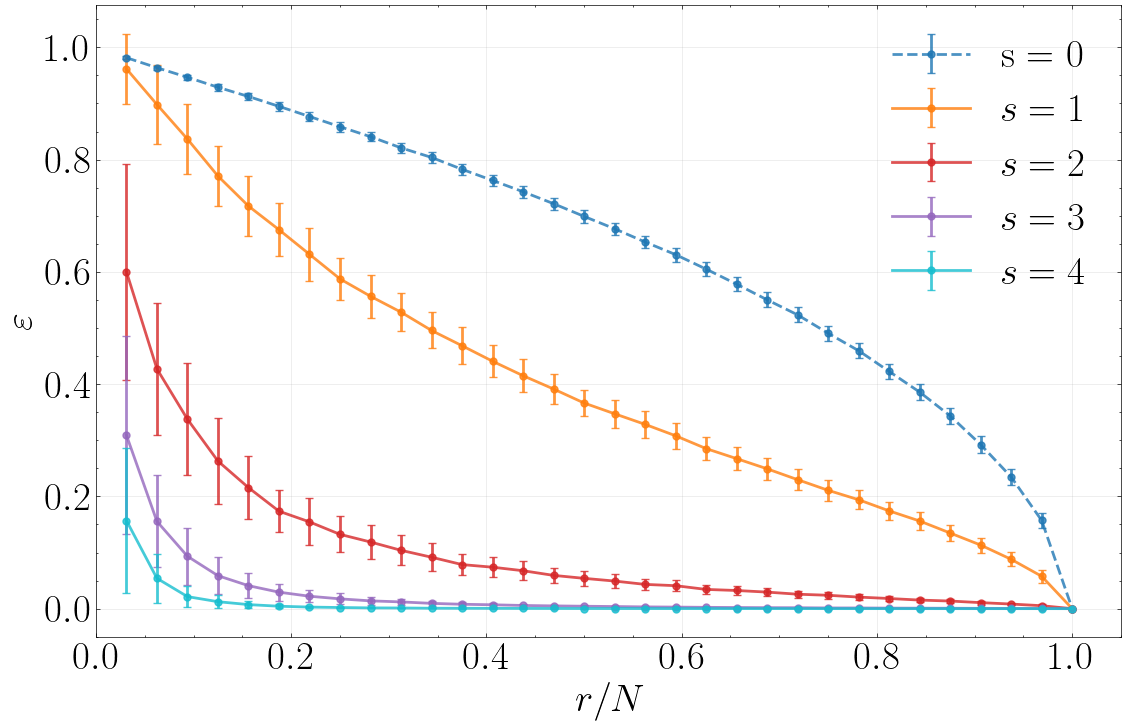

In [9]:
plt.figure(figsize=(12, 8))

# Colors for polynomial cases
colors_poly = ['#ff7f0e', '#d62728', '#9467bd', '#17becf']  # Orange/Red/Purple/Cyan for polynomial

# Filter to only polynomial cases and create simplified labels
polynomial_labels = {
    r'Polynomial $s=1$': '$s=1$',
    r'Polynomial $s=2$': '$s=2$',
    r'Polynomial $s=3$': '$s=3$',
    r'Polynomial $s=4$': '$s=4$',
}

# Plot no decay case first (as dashed line)
if 'No decay' in decay_results:
    data = decay_results['No decay']
    d_values = data['d_values']
    mean_errors = data['mean_errors']
    std_errors = data['std_errors']
    
    d_over_N = np.array(d_values) / N_fixed
    
    plt.errorbar(d_over_N, mean_errors, yerr=std_errors,
                 marker='o', capsize=3, linewidth=2, markersize=5,
                 label='s = 0', color='#1f77b4', 
                 linestyle='--', alpha=0.8)

# Plot polynomial cases with solid lines
for idx, (old_label, new_label) in enumerate(polynomial_labels.items()):
    if old_label in decay_results:
        data = decay_results[old_label]
        d_values = data['d_values']
        mean_errors = data['mean_errors']
        std_errors = data['std_errors']
        
        d_over_N = np.array(d_values) / N_fixed
        
        plt.errorbar(d_over_N, mean_errors, yerr=std_errors,
                     marker='o', capsize=3, linewidth=2, markersize=5,
                     label=new_label, color=colors_poly[idx], 
                     linestyle='-', alpha=0.8)

plt.xlabel(r'$r/N$')
plt.ylabel(r'$\varepsilon$')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xlim(0, 1.05)
plt.tight_layout()
plt.savefig('decay_comparison.pdf', bbox_inches='tight')
plt.show()